**Reducing the Swiss "Foodprint": How an Individual can Readjust their Carbon Output**

This notebook contains detailed data analysis and visualizations of the [Swiss Foodprint]((https://valentinoli.github.io/swiss-foodprint/)) project. Please view the [`README`](../README.md) for overall project goals and background information. The project is hosted on [GitHub](https://github.com/valentinoli/swiss-foodprint).

In [ ]:
# import external libraries
%matplotlib inline
import collections
import inspect
import pickle
import re

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import plotly.graph_objects as go #may not need this
import holoviews as hv
from holoviews import opts
import networkx as nx
from networkx.algorithms import bipartite

# prevent internal problem with networkx from showing error
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

%load_ext autoreload
%autoreload 2

In [74]:
# import local dependencies
import sys
sys.path.insert(1, "scripts")

from plots import *
from impex_data_manipulation import *
from impex_countries import *
from fao_data_manipulation import *
from emissions_data_manipulation import *

The first step is to calculate, for each type of food, how much of what is consumed by the Swiss population is produced within Switzerland versus imported. To do this, we will use data on imports, exports, and domestic production. The imports and exports data are sourced from [Swiss Impex](https://www.gate.ezv.admin.ch/swissimpex/index.xhtml), a website hosted by the Swiss Federal Customs Administration which provides data on Switzerland's global trade activity. Domestic production data comes from [FAO](http://www.fao.org/faostat/en/#data), the Food and Agriculture Organization of the United Nations which offers a variety of agricultural-related data. We fetched fishery data from [here](http://www.fao.org/fishery/statistics/global-commodities-production/query/en).

In theory, the total amount of food consumed in Switzerland (including food waste) can be calculated from these figures:

consumption = domestic production + imports - exports

***
**Data loading and manipulation**
***

In this section, we load and manipulate data on Swiss imports, exports, and domestic production of various food types.

**Note**: All quantities are measured in kilograms, unless otherwise stated.

*Imports and Exports*

First, we load imports-exports data from the [Swiss Impex](https://www.gate.ezv.admin.ch/swissimpex/index.xhtml) into the `impex` dataframe.

In [50]:
impex = load_impex()
impex.head()

type                     fruits                                          \
subtype    plantains_and_others             bananas               dates   
indicator               imports exports     imports  exports    imports   
total                 1444222.0     2.0  92397628.0  36763.0  2706334.0   
Argentina                 396.0     0.0         0.0      0.0        0.0   
Bangladesh                130.0     0.0         0.0      0.0        0.0   
Brazil                   1229.0     0.0      1301.0      0.0        0.0   
Cameroon                 1529.0     0.0     65786.0      0.0        0.0   

type                                                          ...  \
subtype                   figs           pineapples           ...   
indicator   exports    imports  exports     imports  exports  ...   
total       96471.0  3681429.0  56065.0  20809608.0  70821.0  ...   
Argentina       0.0     8783.0      0.0         0.0      0.0  ...   
Bangladesh      0.0        0.0      0.0         0.0      0.0  ...   
Brazil          0.0    42844.0      0.0       891.0      0.0  ...   
Cameroon        0.0        0.0      0.0    213628.0      0.0  ...   

type                        seafood                                            \
subtype    squid_octopus_cuttlefish         shrimp_prawns            molluscs   
indicator                   imports exports       imports  exports    imports   
total                     2363868.0  1415.0     4833926.0  27932.0  3390293.0   
Argentina                    3010.0     0.0       36848.0      0.0        0.0   
Bangladesh                      0.0     0.0      236612.0      0.0        0.0   
Brazil                        496.0     0.0           0.0      0.0        0.0   
Cameroon                        0.0     0.0           0.0      0.0        0.0   

type                                                           
subtype            lobster_crab                fish            
indicator  exports      imports exports     imports   exports  
total        240.0     715883.0  4923.0  34298964.0  153535.0  
Argentina      0.0        144.0     0.0     13205.0       0.0  
Bangladesh     0.0          0.0     0.0         0.0       0.0  
Brazil         0.0        380.0     0.0      6108.0       0.0  
Cameroon       0.0          0.0     0.0       150.0       0.0  

[5 rows x 176 columns]

To ensure that our dataframe is properly processed and handled as is goes through the changes we are about to expose it to, we will pull out one value from it (quantity of kiwi fruits imported from New Zealand) and check at the end to make sure its value is still properly matched with the country and fruit.

In [51]:
impex.loc["New Zealand"].fruits.kiwi_fruit.imports

3241114.0

We then create a dataframe `impex_total` for storing total quantities of indicator variables (such as imports and exports):

In [52]:
# 1. Select only first row (total), creates a series
# 2. Unstack first level (indicator) to create a dataframe
impex_total = impex.iloc[0].unstack("indicator")
impex_total.head()

indicator                      exports     imports
type            subtype                           
animal_products butter       2085954.0    155312.0
                cheese      67285451.0  60637898.0
                eggs          442894.0  36298734.0
                honey         685704.0   8191947.0
                milk_cream  14990772.0  29234598.0

We can safely drop the total row from `impex`:

In [53]:
impex = impex.drop("total")

Let's now further manipulate the `impex` dataframe and add index levels for continents and sub-continents that the countries belong to:

In [58]:
# We load the country-continent info
continents = load_countries_continents()

# We compute the new index
countries_mindex = pd.MultiIndex.from_arrays(continents.values.T, names=continents.columns)
impex_mindex = countries_mindex[countries_mindex.get_level_values(2).isin(impex.index)]

# Reindex such that it matches the incoming multi-index
impex = impex.reindex(impex_mindex.get_level_values(2))

# Finally, apply the new multi-index
impex.set_index(impex_mindex, inplace=True)
impex.index[:5]

MultiIndex([('Africa', 'North Africa',        'Algeria'),
            ('Africa', 'North Africa', 'Canary Islands'),
            ('Africa', 'North Africa',          'Egypt'),
            ('Africa', 'North Africa',          'Libya'),
            ('Africa', 'North Africa',        'Morocco')],
           names=['continent', 'subcontinent', 'country'])

We check that the numbers stay with their indices:

In [48]:
impex.xs("New Zealand", level="country", drop_level=False).fruits.kiwi_fruit.imports

continent  subcontinent  country    
Oceania    Oceania       New Zealand    3241114.0
Name: imports, dtype: float64

The imports of kiwi fruits from New Zealand is correct and we conclude that applying the new index was successful.

<p style="font-size: 12px"><strong>Note:</strong> The impex dataframe should only contain information about food destined for humans. During the data collection phase, we were careful to ensure this was true: all items which can also be imported for the use of animal feed were selected by their subcategory of being specifically for human consumption. </p>

*Domestic Production*

Now, let's load the data on Swiss domestic `production` from [FAO](http://www.fao.org/faostat/en/#data):

In [59]:
production = load_fao()
production.head()

indicator                     production
type            subtype                 
animal_products butter      4.843600e+07
                cheese      2.063360e+08
                eggs        5.763500e+07
                honey       3.084000e+06
                milk_cream  4.795811e+09

<p style="font-size: 12px"><strong>Note</strong>: We were careful that only crops produced for human consumption are measured. This is specified in the FAO metadata.</p>

*Combining imports, exports and domestic production*

Next, we perform an outer join of `impex_total` and `production` to create a meta-dataframe, `suisse` with all total macroeconomic indicators for each commodity subtype:

In [60]:
suisse = impex_total.join(production, how="outer")
suisse.head()

indicator                      exports     imports    production
type            subtype                                         
animal_products butter       2085954.0    155312.0  4.843600e+07
                cheese      67285451.0  60637898.0  2.063360e+08
                eggs          442894.0  36298734.0  5.763500e+07
                honey         685704.0   8191947.0  3.084000e+06
                milk_cream  14990772.0  29234598.0  4.795811e+09

We have three possibilities for each commodity
1. Neither production or import/export values are given or they all sum up to 0
2. Either only production values are given or only import/export values are given
3. Production, import and export values are all given (and are non-zero)

Commodities fulfilling the first condition will be removed and others will be kept.

<p style="font-size: 12px"><strong>Note</strong>: Missing or 0-valued data may be due to either the values actually being 0 or the data not being collected on these items. Since there is no way of knowing which is the case, we will assume that the values are indeed truly 0 to enable their utilization in the analysis.</p>

In [61]:
# Remove subtypes for which all given quantities sum up to 0
subtypes_no_info = suisse.index[suisse.sum(axis=1) == 0]
suisse.drop(subtypes_no_info, inplace=True)

*Computing Estimated Consumption*

Next, we shall add columns for `domestic_consumption`, `imported_consumption` and total `consumption`.

Definitions:
* **domestic consumption**: goods and services consumed in the country where they are produced
* **imported consumption**: goods and services consumed in the country to which they are imported

**Note**: For the calculation of the above quantities we make the following assumptions:

* food waste is not taken into account and is included as being "consumed"
* exported quantity is first satisfied by available produced quantity, and then imported quantity

In [62]:
# If exports > production, then we say all produced quantity
# is exported and the rest of exported quantity is satisfied by imports:
# 1. Set domestic_consumption to zero
# 2. Set imported_consumption to imports-(exports-production)

# If exports <= production, we say all exports
# is satisfied by domestic production: 
# 1. Set domestic_consumption to production-exports
# 2. Set imported_consumption to imports
suisse["domestic_consumption"] = np.where(
    suisse.exports > suisse.production,
    0,
    suisse.production - suisse.exports
)

suisse["imported_consumption"] = np.where(
    suisse.exports > suisse.production,
    suisse.imports - suisse.exports + suisse.production,
    suisse.imports
)

suisse["consumption"] = suisse.domestic_consumption + suisse.imported_consumption

suisse.head()

indicator                      exports     imports    production  \
type            subtype                                            
animal_products butter       2085954.0    155312.0  4.843600e+07   
                cheese      67285451.0  60637898.0  2.063360e+08   
                eggs          442894.0  36298734.0  5.763500e+07   
                honey         685704.0   8191947.0  3.084000e+06   
                milk_cream  14990772.0  29234598.0  4.795811e+09   

indicator                   domestic_consumption  imported_consumption  \
type            subtype                                                  
animal_products butter              4.635005e+07              155312.0   
                cheese              1.390505e+08            60637898.0   
                eggs                5.719211e+07            36298734.0   
                honey               2.398296e+06             8191947.0   
                milk_cream          4.780820e+09            29234598.0   

indicator                    consumption  
type            subtype                   
animal_products butter      4.650536e+07  
                cheese      1.996884e+08  
                eggs        9.349084e+07  
                honey       1.059024e+07  
                milk_cream  4.810055e+09

Let's make sure no consumption values are negative:

In [63]:
suisse[suisse.consumption < 0]

,indicator,exports,imports,production,domestic_consumption,imported_consumption,consumption
type,subtype,,,,,,
animal_products,whey,77624196.0,8145149.0,63000000.0,0.0,-6479047.0,-6479047.0


Apparently, recorded *whey* exports exceed the combined imports and production. We handle this special case by setting the consumption value to zero:

In [64]:
suisse.loc[("animal_products", "whey")]["imported_consumption", "consumption"] = 0

*Carbon Emissions*

Now that we have information on Switzerland's imports, exports, production and consumption, we want to have a look at how this translates in terms of equivalent CO$_2$ production. To do this, we could look at Swiss-specific values for the greenhouse gas production for different food types. However, data from other countries is very sparse and reliable data for many food types is only available for certain countries. 

Comprehensive data is available on meat and cereal production emissions worldwide, however fruit and vegetable figures are much harder to obtain and only a limited number of studies have been carried out. These studies have been accumulated in a [systematic review](https://www.sciencedirect.com/science/article/pii/S0959652616303584) and these values have been used to calculate averages for a number of different kinds of produce. To ensure our results are consistent, we will use this generalization of global average values for all food types.

We load the emission data:

In [68]:
emissions = load_emissions()
emissions.head()

,Median,Mean,Stdev,Min,Max,Q1,Q3,No. of LCA studies,No. of GWP values
name,,,,,,,,,
almond/coconut milk,0.42,0.42,0.03,0.39,0.44,0.39,0.44,1.0,4.0
almonds,1.54,1.74,1.25,0.51,3.77,0.76,2.33,4.0,6.0
anglerfish,12.29,12.29,2.63,10.43,14.15,11.36,13.22,2.0,2.0
apples,0.29,0.36,0.19,0.18,0.89,0.21,0.47,21.0,33.0
apricots,0.43,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0


Then we integrate the median emissions values into the `suisse` dataframe:

In [69]:
suisse = add_emissions_data(suisse, emissions)
suisse.head()

exports     imports   production  \
type            subtype                                        
animal_products butter    2085954.0    155312.0   48436000.0   
                cheese   67285451.0  60637898.0  206336000.0   
                whey     77624196.0   8145149.0   63000000.0   
                eggs       442894.0  36298734.0   57635000.0   
                honey      685704.0   8191947.0    3084000.0   

                         domestic_consumption  imported_consumption  \
type            subtype                                               
animal_products butter             46350046.0              155312.0   
                cheese            139050549.0            60637898.0   
                whey                      0.0                   0.0   
                eggs               57192106.0            36298734.0   
                honey               2398296.0             8191947.0   

                         consumption emissions_category  median_emissions  
type            subtype                                                    
animal_products butter    46505358.0             butter              9.25  
                cheese   199688447.0             cheese              8.55  
                whey             0.0             cheese              8.55  
                eggs      93490840.0               eggs              3.46  
                honey     10590243.0              honey              0.00

<p style="font-size: 12px"><strong>Note:</strong> The emissions categories available were less comprehensive than the FAO/Impex categories. The items lacking emissions values were estimated using the closest available emissions category. For a full list, please see the last 15 lines of <a href="https://drive.google.com/open?id=1KDBiuJ4la_vW3X2_KnD18IQFb00Qoh6B">this file</a>.</p>

So, assuming that domestic transport is negligible, we can estimate the equivalent CO$_2$ emissions for each product type, using the global average values.

In [70]:
# calculate the emissions (resulting from production of the products)
suisse = production_emissions(suisse)
suisse.head()

exports     imports   production  \
type            subtype                                        
animal_products butter    2085954.0    155312.0   48436000.0   
                cheese   67285451.0  60637898.0  206336000.0   
                whey     77624196.0   8145149.0   63000000.0   
                eggs       442894.0  36298734.0   57635000.0   
                honey      685704.0   8191947.0    3084000.0   

                         domestic_consumption  imported_consumption  \
type            subtype                                               
animal_products butter             46350046.0              155312.0   
                cheese            139050549.0            60637898.0   
                whey                      0.0                   0.0   
                eggs               57192106.0            36298734.0   
                honey               2398296.0             8191947.0   

                         consumption emissions_category  median_emissions  \
type            subtype                                                     
animal_products butter    46505358.0             butter              9.25   
                cheese   199688447.0             cheese              8.55   
                whey             0.0             cheese              8.55   
                eggs      93490840.0               eggs              3.46   
                honey     10590243.0              honey              0.00   

                         emissions_sans_transport  
type            subtype                            
animal_products butter               4.301746e+08  
                cheese               1.707336e+09  
                whey                 0.000000e+00  
                eggs                 3.234783e+08  
                honey                0.000000e+00

The final column, `emissions_sans_transport`, shows the total CO$_2$ equivalent (kg) that would be produced if everything that was consumed in Switzerland was domestically produced, i.e. no transport emissions were considered and Swiss-specific CO$_2$ emissions were used for meat and cereal production. Evidently, it is not possible to produce everything that a current consumer buys locally, so in the following analysis we will consider the effect that these imported products and 'food miles' have on the CO$_2$ emissions resulting from Swiss consumption. 

*Transportation*

Let's load the distances between Switzerland and other countries. To prepare for an augmentation of our analysis later on, we will also load distances to the Netherlands.

In [71]:
try:
    countries = pd.read_pickle("countries.pkl")
except:
    countries = country_distances()

countries.head()

,coord,distance_CH,distance_NL
country,,,
Algeria,"[28.0000272, 2.9999825]",2136.0,2659.0
Canary Islands,"[28.2935785, -16.6214471211441]",2983.0,3155.0
Ceuta,"[35.888361, -5.304138]",1654.0,1943.0
Ceuta/Melilla,"[36.7137977, -4.272712]",1525.0,1825.0
Egypt,"[26.2540493, 29.2675469]",2938.0,3531.0


Next, we load data about transports of imported products from the Impex:

In [81]:
transport = load_impex_transport()
transport.tail(10)

food_type                                 cereals    potatoes  \
commercial_partner mode_of_transport                            
Zambia             total                      0.0         0.0   
Zimbabwe           Air traffic              145.0         0.0   
                   Inland waterways           0.0         0.0   
                   Road traffic               0.0         0.0   
                   total                    145.0         0.0   
total              Air traffic            15007.0        10.0   
                   Inland waterways    86109369.0         0.0   
                   Rail traffic       108157836.0         5.0   
                   Road traffic        98237354.0  57721581.0   
                   total              292519566.0  57721596.0   

food_type                             other_fresh_fruits_vegetables  \
commercial_partner mode_of_transport                                  
Zambia             total                                      208.0   
Zimbabwe           Air traffic                              10407.0   
                   Inland waterways                             0.0   
                   Road traffic                            178448.0   
                   total                                   188855.0   
total              Air traffic                            8955957.0   
                   Inland waterways                       4241550.0   
                   Rail traffic                          19303446.0   
                   Road traffic                         763220093.0   
                   total                                795721046.0   

food_type                                   fish         meat  dairy_products  
commercial_partner mode_of_transport                                           
Zambia             total                     0.0          0.0             0.0  
Zimbabwe           Air traffic               0.0          0.0             0.0  
                   Inland waterways          0.0          0.0             0.0  
                   Road traffic              0.0        578.0             0.0  
                   total                     0.0        578.0             0.0  
total              Air traffic          813671.0    4476877.0         56453.0  
                   Inland waterways      82829.0     597599.0          4256.0  
                   Rail traffic          11525.0    5869676.0       5360330.0  
                   Road traffic       13125918.0  130663048.0     124257694.0  
                   total              14033943.0  141607200.0     129678733.0

We remove the totals for each country and store in a separate dataframe:

In [82]:
transport_total = transport.xs("total", level=1)
transport = transport.drop(index="total", level=1)

Next, we calculate the fractions for each food group transported by each method of transport:

In [83]:
np.seterr("ignore")  # ignore divisions by 0 (when the total imports is 0)
transport[
    [
        "cereals",
        "potatoes",
        "other_fresh_fruits_vegetables",
        "fish",
        "meat",
        "dairy_products",
    ]
] = transport.apply(calculate_percent_by_method, args=(transport_total,), axis=1)

transport.head(10)

food_type                              cereals  potatoes  \
commercial_partner mode_of_transport                       
Afghanistan        Road traffic       0.000000       0.0   
Albania            Air traffic        0.000000       0.0   
                   Road traffic       0.000000       0.0   
Algeria            Air traffic        0.000000       0.0   
                   Rail traffic       0.000000       0.0   
                   Road traffic       1.000000       0.0   
Andorra            Road traffic       0.000000       1.0   
Antigua            Road traffic       0.000000       0.0   
Argentina          Air traffic        0.000000       0.0   
                   Inland waterways   0.394078       0.0   

food_type                             other_fresh_fruits_vegetables  fish  \
commercial_partner mode_of_transport                                        
Afghanistan        Road traffic                            0.000000   0.0   
Albania            Air traffic                             0.039066   0.0   
                   Road traffic                            0.960934   0.0   
Algeria            Air traffic                             0.137731   0.0   
                   Rail traffic                            0.000000   0.0   
                   Road traffic                            0.862269   0.0   
Andorra            Road traffic                            0.000000   0.0   
Antigua            Road traffic                            1.000000   0.0   
Argentina          Air traffic                             0.025398   0.0   
                   Inland waterways                        0.003021   0.0   

food_type                                 meat  dairy_products  
commercial_partner mode_of_transport                            
Afghanistan        Road traffic       0.000000             0.0  
Albania            Air traffic        0.000000             0.0  
                   Road traffic       0.000000             0.0  
Algeria            Air traffic        0.000000             0.0  
                   Rail traffic       0.000000             0.0  
                   Road traffic       0.000000             0.0  
Andorra            Road traffic       0.000000             0.0  
Antigua            Road traffic       0.000000             0.0  
Argentina          Air traffic        0.162222             1.0  
                   Inland waterways   0.000000             0.0

# TODO SOME TEXT ABOUT THE BELOW IMAGE

<img width="400" height="400" src="https://icmattermost.epfl.ch/files/5zr1jyriupfsfgmr4dtg155ssw/public?h=_GPk0xYK1I16gWsY3GuIsrFC5bTb3Ioh4_W3h3oYDs8">

In [ ]:
# divide all the values by 1000 to convert to kg CO2e / kg km
transportCO2 = {
    "Air traffic": 0.000733,
    "Rail traffic": 0.000037,
    "Road traffic": 0.000303,
    "Inland waterways": 0.000019,
}

***
**Data analysis and visualization**
***

*Imports and Exports per meta food type*

In [87]:
# 1. Group by meta-type
# 2. Sum the totals
# 3. Unstack the columns to create a Series
impex_total_metatype = impex_total.groupby("type").sum().unstack()

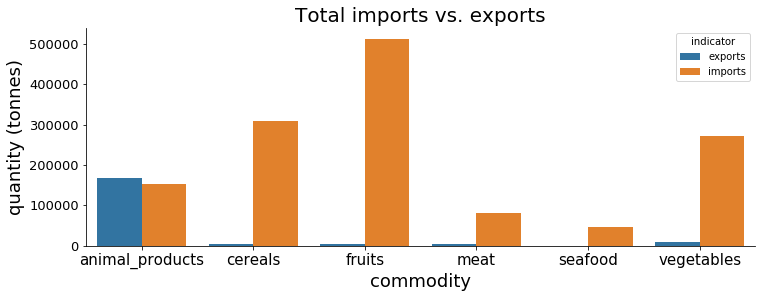

In [88]:
plt.figure(figsize=(12, 4))
ax = sns.barplot(
    x=impex_total_metatype.index.get_level_values("type"),
    y=impex_total_metatype.values / 1000,  # kg --> tonnes
    hue=impex_total_metatype.index.get_level_values("indicator"),
)

plt.xticks(fontsize=15)
plt.yticks(fontsize=13)
plt.xlabel('commodity', fontsize=18)
plt.ylabel('quantity (tonnes)', fontsize=18)
plt.title('Total imports vs. exports', fontsize=20)

sns.despine()
# plt.savefig("../docs/img/total_imports_vs_exports.jpg", dpi=100, bbox_inches='tight')

Switzerland imports many more fruits, vegetables and meats than it exports. The `animal_products` category is interesting, because import and export quantities are about equal. What would make the most sense is if Switzerland imports different animal products than it exports (rather than the same products being both imported and exported). Let's test this theory by looking at imports and exports for the subcategories of `animal_products`:

In [89]:
impex_total_animal_prods = (
    impex_total.loc["animal_products"]
    .groupby("subtype")
    .sum()
    .unstack()
)

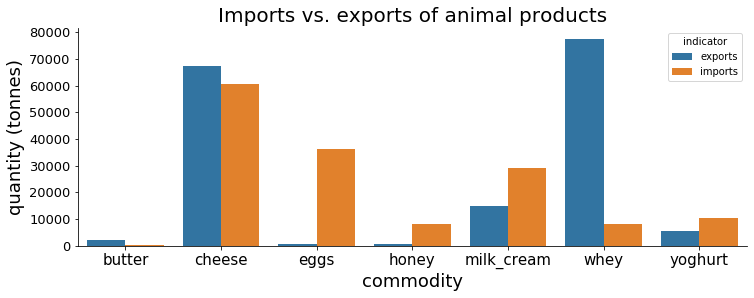

In [90]:
plt.figure(figsize=(12, 4))
ax = sns.barplot(
    x=impex_total_animal_prods.index.get_level_values("subtype"),
    y=impex_total_animal_prods.values / 1000,  # kg --> tonnes
    hue=impex_total_animal_prods.index.get_level_values("indicator"),
)

plt.xticks(fontsize=15)
plt.yticks(fontsize=13)
plt.xlabel('commodity', fontsize=18)
plt.ylabel('quantity (tonnes)', fontsize=18)
plt.title('Imports vs. exports of animal products', fontsize=20)

sns.despine()
# plt.savefig("../docs/img/imports_vs_exports_animal_products.jpg", dpi=100, bbox_inches='tight')

This graph brings more light to the topic. Cheese, a category of which there are many different flavors and consumers like variety, is both heavily imported and exported, likely giving consumers access to a wider variety of cheese types. Eggs, on the other hand, are nearly exclusively imported, while whey is mostly exported.

The butter category of this graph is a good transition to the continuation of the analysis; just because butter is hardly imported nor exported does not mean the Swiss do not eat butter! Rather, imports and exports are only part of the broader picture since domestic production is another important consideration. One possible hypothesis for why butter is neither imported nor exported in large quantities is because domestic production is nearly equal to domestic consumption.

*Swiss Consumption*

In [ ]:
consumption = suisse.copy()
consumption = consumption[["domestic_consumption", "imported_consumption", "consumption"]]

In [ ]:
# Compute ratio of domestic vs. imported consumption per metatype
consumption_by_type = consumption.groupby("type").sum()
consumption_by_type["domestic_consumption"] = 100 * (
    consumption_by_type.domestic_consumption / consumption_by_type.consumption
)
consumption_by_type["imported_consumption"] = 100 * (
    consumption_by_type.imported_consumption / consumption_by_type.consumption
)
consumption_by_type.drop("consumption", axis=1, inplace=True)
consumption_by_type = consumption_by_type.reindex(
    ["fruits", "vegetables", "cereals", "animal_products", "meat", "seafood"]
)
consumption_by_type

In [85]:
plot_consumption_per_type(consumption_by_type)

In [ ]:
percentage = glimpse()
print(str(round(percentage)) + "% of Switzerland's total imports come from countries within a 1000km radius.")

#### Bipartite graph between continents and meta food groups, weighted by amounts of food imported from those continents

In [ ]:
# make the nodes: continents on the left, food groups on the right
continents = impex.index.get_level_values(0).unique().array
meta_food_groups = impex.columns.levels[0].array
bi = nx.Graph()
bi.add_nodes_from(continents, bipartite=1)
bi.add_nodes_from(meta_food_groups, bipartite=0)

# make an edge between each continent and each food group
edges = []
for continent in continents:
    for food in meta_food_groups:
        edges.append((continent, food))
        
bi.add_edges_from(edges, weight=3)

In [ ]:
# calculate the initial raw weights, which is the total amount of food for each continent-food pair
weights = []
for continent in continents:
    for food in meta_food_groups:
        total_food_amount = impex.xs(continent)[food].xs('imports', level=1, axis=1).to_numpy().sum()
        weights.append(total_food_amount)
        
# incorporate these weights into the data for each edge
for num, name in enumerate(bi.edges(data=True)):
    name[2]['weight'] = weights[num]

In [ ]:
#make a list of all the weights so can edit them
all_weights = []
for (node1,node2,data) in bi.edges(data=True):
    all_weights.append(data['weight'])
    #print(data['weight']) # this is totals by continent per meta food group

# normalize the weights so they are appropriate for the graph
for num, wt in enumerate(all_weights):
    all_weights[num] = wt*len(continents)*5/sum(weights)
    
# incorporate the normalized weights into the edge data for use in the graph
for num, name in enumerate(bi.edges(data=True)):
    name[2]['weight'] = all_weights[num]


top = nx.bipartite.sets(bi)[0]
pos = nx.bipartite_layout(bi, top)

# the old, non-interactive graph
#nx.draw_networkx(bi, pos, font_size=12, node_size=900, node_color='red', node_shape='s', width=all_weights)

In [ ]:
# make an interactive bipartite graph with Holoviews and Bokeh
bipartite = hv.Graph.from_networkx(bi, pos, width=all_weights)

# create text labels for each of the nodes
labs = ['Africa', 'America', 'Asia', 'Europe','Oceania','animal products', 'cereals', 'fruits', 'meat', 'seafood', 'vegetables']
labels = hv.Labels({('x', 'y'): bipartite.nodes.array([0,1]), 'text': labs}, ['x', 'y'], 'text')

# plot the graph with labels
hv.extension('bokeh')
# this padding feature was working previously and then broke, so I edited it a bit...
#padding = dict(x=(-1.3, 1.3), y=(-0.9, 1)) # make graph display slightly larger than data
#(bipartite*labels).relabel("Food Type Imports by Continent").redim.range(**padding).opts(
(bipartite*labels).relabel("Food Type Imports by Continent").opts(
    opts.Labels(text_color='text', cmap='Category20', yoffset=0.13, fontsize=14, padding=0.2),
    #opts.Points(color='black', size=25), 
    opts.Graph(node_size=30, inspection_policy='edges', fontsize={'title':20},
               node_hover_fill_color='red', edge_line_width='weight', xaxis=None, yaxis=None, node_fill_color='lightgray',
               edge_hover_fill_color='red', frame_height=400, frame_width=600, padding=((0.1, 0.15), (0.1, 0.2))))

In [ ]:
# TODO: change the weights that show when hovering--these are the normalized weights, we want the actual kg of food
# TODO: figure out why the hover edges are green instead of red
# TODO: find a way to color the continent labels one color and the food labels another color
# TODO: remove the "start" and "end" in the hover labels, just say continent and food
# TODO MAYBE: add a widget to toggle between inspection_policy of edges vs nodes

In [ ]:
# plotting and saving the Sankey diagram to html
labels = ['Africa', 'America', 'Asia', 'Europe','Oceania','animal_products', 'cereals', 'fruits', 'meat', 'seafood', 'vegetables']
colors = ['skyblue', 'yellow', 'orange', 'violet', 'green', 'maroon', 'darkblue', 'seashell', 'lavenderblush', 'lightpink', 'turquoise']

sources = []
targets = []
weights = []
link_colors = []
for (left_node, right_node, data) in bi.edges(data=True):
    weight = data['weight']
    sources.append(labels.index(left_node))
    targets.append(labels.index(right_node))
    weights.append(weight)
#    link_colors.append(colors[labels.index(left_node)])

import plotly.graph_objects as go

fig = go.Figure(data=[
    go.Sankey(
        node = dict(
            pad=10,
            thickness=10,
            line=dict(color = "black", width = 0.5),
            label=labels,
            color = colors),
        link = dict(
            source=sources,
            target=targets,
            value=weights,
#            color=link_colors
        )
    )
])

fig.update_layout(title_text="Food Type Imports by Continent", 
                  font_size=12)
fig.show()

# from plotly.offline import plot
# plot(fig, filename='../docs/_includes/sankey_diagram.html', include_plotlyjs='directory')

Transport methods for different commodoties in the USA are described in detail in the paper *Food-Miles and the Relative Climate Impacts of Food Choices in the United States* (Weber and Matthews, 2008). These values, or similar data for other countries worldwide could be used to estimate the transport means for different products and thus the impact this transport has on emissions for each product. Perishable products more frequently have to be transported by air, and therefore have a significantly larger carbon footprint.

---

## Calculating the CO2 emissions by food type based on where it is imported from

We will now use the country-specific and food item-specific data to calculate carbon costs. For each country and food item pair, we will first calculate how much of that food item imported from that country is consumed by Swiss consumers. This relies upon assumptions that we made previously (mentioned here). The two categories this data processing can fall into are:

* If the exported amount of a given food item is less than what is domestically produced, we assume that all of the Swiss produce is exported first before any of the imports start getting exported. That means there will still be some leftover Swiss-produced food available for Swiss consumption, in addition to all of the imported food from all other countries.

* If, however, there is more of a given food item exported than domestically produced, we must transition to the situation where all of the Swiss-produced goods are exported and some of the imported goods are also exported. In this case, we will assume that each country's imports are exported in an equal percentage (e.g. if Switzerland imports 100 kg of bananas from Country X and 50 kg of bananas from Country Y, and the deficit between Switzerland's production and its exports is 10 kg, a fixed percentage of bananas from each country will be assumed to be exported while the remainder is consumed in Switzerland). Hence, the fraction of that food item from that country consumed in Switzerland is (the total amount of that food item imported from that country) / (the total imports across all countries for that food item). This fraction is multiplied by the total amount of that food item consumed in Switzerland to get results by country.

In [ ]:
# first manipulate the data to prepare for using it
impex_countries = impex.stack(["type", "subtype"]).drop(columns=["exports"]).reset_index()
impex_countries["product"] = impex_countries["subtype"]
impex_countries = impex_countries.set_index(["type", "subtype", 'continent', 'country']).drop(columns = 'subcontinent')

In [ ]:
# calculate, for each country and food item pair, how much of that food item imported from that country is consumed
# by Swiss consumers
def find_consump(row):
    # if the exported amount of this food item is less than what is domestically produced, then
    # all imports go towards Swiss consumption (due to earlier assumptions we made about Swiss production
    # being the source of exports before imports being exported)
    if suisse.xs(row['product'], level=1)['domestic_consumption'][0] > 0:
        return row.imports
    else:
        # if everything which is produced in Switzerland is also exported (domestic_consumption == 0), then
        # some of the imports may also be exported, so the amount of imports consumed in Switzerland is taken
        # as the fraction of (the amount imported from that country) / (total imported amount from all countries)
        denominator = suisse.xs(row['product'], level=1)['imports'][0]
        fraction = row.imports/denominator
        return fraction * suisse.xs(row['product'], level=1)['consumption'][0]

# apply the function to all rows of the dataframe
impex_countries['swiss_consumption'] = impex_countries.apply(find_consump, axis=1)

In [ ]:
impex_countries.head()

For some reason, there is no transport data for Libya. As we can see here, however, there are no rows of data from Libya which have a non-zero `swiss_consumption`. This means there is nothing imported from Libya which is consumed in Switzerland (it is either all exported or there are no imports).

In [ ]:
libya = impex_countries.xs("Libya", level="country")
libya = libya[libya.swiss_consumption != 0]
len(libya)

This is true for the following countries and we'll drop them from the `impex_countries` dataframe:

In [ ]:
countries_no_transport_data = [
    "Libya",
    "Angola",
    "Eritrea",
    "Sudan",
    "St Lucia",
    "Seychelles",
    "Amer. Virgin",
    "Curaçao",
    "Greenland",
    "Guiana, French",
    "Faeroe Islands",
]

In [ ]:
impex_countries.reset_index(inplace=True)

In [ ]:
impex_countries = impex_countries[~impex_countries.country.isin(countries_no_transport_data)]

The next step is to convert the `impex_countries` dataframe, the amount by country and by food item which is eaten in Switzerland, to the carbon costs associated with each country/food item pair. 

In [ ]:
# map the categories used by the transport data to the categories used in
# our dataframe of imports per country and food
colmap = {
    "animal_products": "dairy_products",
    "meat": "meat",
    "fruits": "other_fresh_fruits_vegetables",
    "vegetables": "other_fresh_fruits_vegetables",
    "cereals": "cereals",
    "seafood": "fish",
}

## TODO: 
Modify the `swiss_comsumption_transport` function (or do it after the function) to change the potatoes value. We have transport data specifically for potatoes, but all other fruits and vegetables are lumped into one category together. As of now, the potatoes are included with all the other fruits and vegetables.

In [ ]:
pd.options.mode.chained_assignment = None # prevent the set with copy warning, which is not applicable in this
                                      # case since we are creating a new column (but pandas triggers the warning anyway)
impex_countries['kg_CO2e_transport'] = impex_countries.apply(swiss_consumption_transport, axis=1, args=(transport, transportCO2, countries, colmap))
impex_countries['kg_CO2e_transport_via_nl'] = impex_countries.apply(swiss_consumption_transport, axis=1, args=(transport, transportCO2, countries, colmap), NL=True)

In [ ]:
# create the index again to get back to a multiindex dataframe
impex_countries.set_index(['type', 'subtype', 'continent', 'country'], inplace=True)

In [ ]:
impex_countries.tail(20)

In [ ]:
# now add a column which is carbon cost of transport + inherent carbon cost of producing the item
food_list = np.array(impex_countries.index.get_level_values(level=1))
impex_countries['total_kg_CO2e'] = impex_countries['kg_CO2e_transport'] + \
                            suisse.iloc[suisse.index.get_level_values(1).isin(food_list)].median_emissions * impex_countries['swiss_consumption']

In [ ]:
# show a slice of the dataframe (that has non-zero values) to demonstrate what data it has
impex_countries.iloc[1420:1426]

In [ ]:
# here is how to get specific carbon values for groups of items
impex_countries.iloc[impex_countries.index.get_level_values(0) == 'meat'].total_kg_CO2e.sum()

In [ ]:
meta_food_CO2 = impex_countries.total_kg_CO2e.groupby("type").sum()
meta_food_consumption = impex_countries.swiss_consumption.groupby('type').sum()
meta_normalized_CO2 = meta_food_CO2 / meta_food_consumption

In [ ]:
plt.figure(figsize=(12, 4))

ax = sns.barplot(
    x=meta_normalized_CO2.index.get_level_values("type"),
    y=meta_normalized_CO2.values 
)

plt.xticks(fontsize=15)
plt.yticks(fontsize=13)
plt.xlabel('commodity', fontsize=18)
plt.ylabel('kg CO2e per kg food', fontsize=18)
plt.title('Carbon cost normalized by consumption', fontsize=20)
sns.despine()
# plt.savefig("../docs/img/carbon_normalized_consumption.jpg", dpi=100, bbox_inches='tight');

Let's now look at a plot which compares the inherent carbon cost of a food item (that is, its global average emission value for production multiplied by how much of that item is consumed in Switzerland) with its Swiss-specific carbon cost (the inherent cost plus the transport carbon emissions).

In [ ]:
# you can use this dataframe instead of the entire impex_countries in the next few cells if you want the scatterplot and
# stacked bar chart to have fewer metacategories

stacked = impex_countries.drop('meat', level=0)
stacked = stacked.drop('fruits', level=0)
stacked = stacked.drop('seafood', level=0)
#stacked = stacked.drop('vegetables', level=0)
stacked = stacked.drop('cereals', level=0)
stacked = stacked.drop('animal_products', level=0)
stacked

In [ ]:
# IF YOU WANT THE SCATTER PLOT OR STACKED BAR PLOT BELOW TO HAVE DIFFERENT CATEGORIES, change what gets
# dropped from `stacked` above (or use impex_countries instead of `stacked`)

# pull out the emissions for Switzerland specifically from the impex_countries df, and the inherent emissions
# value for each food type from the emissions df
food_CO2_consumption = pd.DataFrame(stacked.groupby('subtype').sum()) # put 'stacked' df here
food_CO2_consumption = food_CO2_consumption.drop(columns=['imports'])
emissions_median = pd.DataFrame(emissions['Median'])
lefton = emissions_median.index.to_numpy()

In [ ]:
# merge everything of interest for this plot into one df for easy processing
inherent_and_swiss = emissions_median.merge(food_CO2_consumption, right_index=True, left_on = lefton)
inherent_and_swiss.drop(labels="key_0", axis=1, inplace=True)
# since a food item could have a high amount of CO2 just because a lot of it is consumed, normalize
# by the amount consumed in Switzerland (so this new column is kg CO2e per kg food)
inherent_and_swiss['norm_CO2e'] = inherent_and_swiss['total_kg_CO2e'] / inherent_and_swiss['swiss_consumption']
# make a column of CO2e due to just the inherent production costs
inherent_and_swiss['kg_CO2e_inherent'] = inherent_and_swiss['total_kg_CO2e'] - inherent_and_swiss['kg_CO2e_transport']
inherent_and_swiss['total_kg_CO2e_nl'] = inherent_and_swiss['kg_CO2e_inherent'] + inherent_and_swiss['kg_CO2e_transport_via_nl']
inherent_and_swiss.head()

In [ ]:
go = inherent_and_swiss[['total_kg_CO2e','total_kg_CO2e_nl']]
go.columns = ['transport','transport_nl']
go = pd.DataFrame(go.stack())
go.reset_index(inplace=True)
go.columns = ['product','transport','kg_CO2e']
go

In [ ]:
goo = inherent_and_swiss[['kg_CO2e_transport','kg_CO2e_transport_via_nl']]
goo.columns = ['inherent','inherent_nl']
goo = pd.DataFrame(goo.stack())
goo.reset_index(inplace=True)
goo.columns = ['product','transport','total_kg_CO2e']
goo = goo.merge(inherent_and_swiss[['kg_CO2e_inherent']].reset_index(), left_on='product', right_on='name').drop(columns=['name'])
goo = goo.drop(columns=['total_kg_CO2e'])
goo.columns = ['product','transport','kg_CO2e']
goo


In [ ]:
inherent = np.array(inherent_and_swiss['Median'])
swiss_co2_norm = np.array(inherent_and_swiss['norm_CO2e'])
food_names = np.array(inherent_and_swiss.index)

# make a dictionary to match the various categories and data subsets
matcher = {
    "CO2e per kg of food produced":inherent,
    "Swiss-specific kg CO2e per kg food":swiss_co2_norm,
    "Food item":food_names
}
co2_scores = pd.DataFrame(matcher).round(4)

In [ ]:
# INTERACTIVE SCATTER PLOT. This visualization has now been replaced by the stacked bar plots, 
# but please leave this code in case we need to return to this later for any reason.

# import plotly.express as px
# import plotly.offline as pyo

# # Set notebook to work in offline mode
# pyo.init_notebook_mode()

# fig = px.scatter(
#     co2_scores,
#     x="Swiss-specific kg CO2e per kg food",
#     y="CO2e per kg of food produced",
#     hover_name="Food item",
# )

# fig.update_layout(
#     title={
#         "text": "Carbon emissions with and without transport to Switzerland",
#         "y": 0.95,
#         "x": 0.5,
#         "xanchor": "center",
#         "yanchor": "top",
#     },
#     #title_font=dict(size=20),
# )

# fig.show()

In [ ]:
# the above graph is difficult to interpret, so let's convert it to a stacked barplot instead
sns.set(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(9, 9)) # CHANGE THE SIZE HERE AS APPROPRIATE FOR THE METACATEGORY

# Plot the total carbon cost (background)
sns.set_color_codes("pastel")
sns.barplot(x='kg_CO2e', y='product', hue='transport', data=go, orient = 'h', palette=['r','b'])

# Plot just the inherent carbon cost of production on top
sns.set_color_codes("muted")
sns.barplot(x='kg_CO2e', y='product', hue='transport', data=goo, orient = 'h', palette=['r','b'])


In [ ]:
# the above graph is difficult to interpret, so let's convert it to a stacked barplot instead
sns.set(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(6, 6)) # CHANGE THE SIZE HERE AS APPROPRIATE FOR THE METACATEGORY

# Plot the total carbon cost (background)
sns.set_color_codes("muted")
sns.barplot(x=inherent_and_swiss.total_kg_CO2e, y=inherent_and_swiss.index, orient = 'h',
            label="Transport", color="b")

# Plot just the inherent carbon cost of production on top
sns.set_color_codes("pastel")
sns.barplot(x=inherent_and_swiss.kg_CO2e_inherent, y=inherent_and_swiss.index, orient = 'h',
            label="Inherent", color="b")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(ylabel="food",
       xlabel="CO2e (kg)")
plt.yticks(rotation='horizontal')
plt.title('Inherent vs Transport Carbon Costs')
sns.despine(left=True, bottom=True)

### Let's look into fruits in detail.
 

In [ ]:
# import amounts, amounts consumed in Switzerland, and kg of CO2e by each fruit
fruits_co2 = impex_countries.iloc[impex_countries.index.get_level_values(0) == 'fruits'].groupby('subtype').sum()
fruits_co2.head()

In [ ]:
plt.figure(figsize=(12, 4))
ax = sns.barplot(
    x=fruits_co2.index.get_level_values("subtype"),
    y=fruits_co2['total_kg_CO2e'] / fruits_co2['swiss_consumption'],
)

ax.set(
    title="Carbon cost of fruits normalized by their consumption", xlabel="fruit", ylabel="CO2e per kg fruit consumed"
)
plt.xticks(rotation=90)
sns.despine();

#### What if we thought a little bit about seasonality...

Let's compare tomatoes grown by different methods. For example, tomatoes grown outside of a greenhouse have a lower carbon impact than tomatoes grown in greenhouses. But how does the carbon cost of transport compare to the carbon cost of these higher intensity methods? We can quantify the comparison by looking at the carbon costs of the amount of tomatoes consumed in Switzerland if they were grown in Switzerland or grown in other countries, then transported. For each country, we will compare three growing methods. The countries included in this analysis are the warmer neighboring countries of Spain and Morocco, the biggest tomato trading partners of Switzerland within and outside of Europe, respectively. (We chose to pick one country outside of Europe even though it is the third biggest tomato trading partner, to account for a higher distance of transport.)

In [ ]:
# first quantify how many tomatoes come from these two countries, just to show how large of tomato trading partners they are
spain_produced_swiss_consumed_tomatoes = int(impex_countries.loc['vegetables'].loc['tomatoes'].loc['Europe'].loc['Spain'].swiss_consumption)
morocco_produced_swiss_consumed_tomatoes = int(impex_countries.loc['vegetables'].loc['tomatoes'].loc['Africa'].loc['Morocco'].swiss_consumption)
total_tomatoes = int(impex_countries.loc['vegetables'].loc['tomatoes'].sum().swiss_consumption)
spain_tomatoes_perc = round(spain_produced_swiss_consumed_tomatoes * 100 / total_tomatoes, 1)
morocco_tomatoes_perc = round(morocco_produced_swiss_consumed_tomatoes * 100 / total_tomatoes, 1)

print("Spain produces {}% of swiss-consumed tomatoes and Morocco produces {}%, out of a total of {} kg of tomatoes.".format(spain_tomatoes_perc, morocco_tomatoes_perc, total_tomatoes))

In [ ]:
tomatoes = load_tomatoes(suisse,transport,transportCO2,countries)
tomatoes

In this dataframe, the columns are:
* `Median`: the inherent median carbon emission value for tomatoes grown by a given production method (in kg CO2e)
* `produced_in_CH_month`: kg of CO2e produced if the amount of tomatoes consumed in Switzerland were all produced within Switzerland by that method of production
* `imported_from_ES_month`: kg of CO2e produced if the amount of tomatoes consumed in Switzerland were all produced in Spain by that method of production and then imported
* `imported_from_MO_month`: same as `imported_from_ES_month` except produced in and imported from Morocco
* `transport_percent`: the percentage of the CO2e which results from the transport cost from Spain, in comparison to the inherent production cost

In [ ]:
tomatoes_for_graph = tomatoes.drop(columns=['transport_percent', 'Median'])
tomatoes_for_graph = tomatoes_for_graph.rename(columns={'produced_in_CH_month':'Switzerland', 'imported_from_ES_month':'Spain', 'imported_from_MO_month':'Morocco'})
tomatoes_for_graph = tomatoes_for_graph.stack()

In [ ]:
plt.figure(figsize=(12, 8))
ax = sns.barplot(
    x=tomatoes_for_graph.index.get_level_values(1),
    y=tomatoes_for_graph.values,
    hue=tomatoes_for_graph.index.get_level_values(0),
)

plt.xticks(fontsize=15)
plt.yticks(fontsize=13)
plt.xlabel('country of production', fontsize=18)
plt.ylabel('monthly CO2e emitted (kg)', fontsize=18)
plt.title('Comparison of growing methods and location for tomatoes', fontsize=20)

plt.setp(ax.get_legend().get_texts(), fontsize='16') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='18') # for legend title

sns.despine()
# plt.savefig("../docs/img/tomatoes.jpg", dpi=100, bbox_inches='tight')

---

# Comparison of current and recommended diets

Let's start by making a dataframe of every food item with: how much is consumed in Switzerland, how much is consumed per person per day, and how much is recommended by the Swiss government for a healthy diet.

In [ ]:
daily_consumption = impex_countries.groupby(['type','subtype']).sum().drop(columns=['imports', 'kg_CO2e_transport', 'kg_CO2e_transport_via_nl', 'total_kg_CO2e'])
# From FAO, the population of Switzerland in 2017 was 8455804 people
# also divide by 365 days per year, and convert kg --> g
daily_consumption['g_per_person_per_day'] = daily_consumption['swiss_consumption'] * 1000 / (8455804 * 365)
daily_consumption.head()

In [ ]:
daily_consumption.groupby('type').sum()

In [ ]:
daily_consumption.sum()

Well, people definitely eat more than 400 grams of food per day. On top of that, the proportions amongst the food groups are way off! So we will leave this as a "hole in our data" and maybe discuss later.

---
# Histogram of carbon emissions by food group

In [ ]:
histogram_df = impex_countries.groupby(['type','subtype']).sum().drop(columns=['imports', 'kg_CO2e_transport', 'kg_CO2e_transport_via_nl'])
histogram_df['kg_CO2_per_kg_food'] = histogram_df['total_kg_CO2e'] / histogram_df['swiss_consumption']
histogram_df.drop(columns=['swiss_consumption', 'total_kg_CO2e'], inplace=True)
histogram_df.head()

In [ ]:
animal_prods_hist = np.array(histogram_df.loc['animal_products'])
meat_seafood_hist = np.array(histogram_df.loc[['seafood', 'meat']])
vegan_sourced_hist = np.array(histogram_df.loc[['fruits', 'vegetables', 'cereals']])

In [ ]:
bins = np.linspace(0, 35, 40)

plt.figure(figsize=(12,6))

plt.hist(meat_seafood_hist, bins, alpha=0.9, label='meat_seafood')
plt.hist(vegan_sourced_hist, bins, alpha=0.5, label='vegan')
plt.hist(animal_prods_hist, bins, alpha=0.5, label='animal_prods')

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('kg CO2e per kg food', fontsize=18)
plt.ylabel('number of food items', fontsize=18)
plt.title('Total carbon cost of meats, animal products, and plant-based foods', fontsize=20)

plt.yscale('log')
plt.legend(loc='upper right', fontsize=16)
# plt.savefig("../docs/img/histogram.jpg", dpi=100, bbox_inches='tight')